## 0. Load Required Libraries

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import src.util as util

## 1. Import Configuration File

In [111]:
config_data = util.load_config()

## 2. Load Dataset

In [112]:
def load_dataset(config_data: dict) -> pd.DataFrame:
    # Load every set of data
    x_train = util.pickle_load(config_data["train_set_path"][0])
    y_train = util.pickle_load(config_data["train_set_path"][1])

    x_valid = util.pickle_load(config_data["valid_set_path"][0])
    y_valid = util.pickle_load(config_data["valid_set_path"][1])

    x_test = util.pickle_load(config_data["test_set_path"][0])
    y_test = util.pickle_load(config_data["test_set_path"][1])

    # Concatenate x and y each set
    train_set = pd.concat([x_train, y_train], axis = 1)
    valid_set = pd.concat([x_valid, y_valid], axis = 1)
    test_set = pd.concat([x_test, y_test], axis = 1)

    # Return 3 set of data
    return train_set, valid_set, test_set

In [113]:
train_set, valid_set, test_set = load_dataset(config_data)

## 3. Feature Engineering

### 3.1 Stock Return Data Transform

In [114]:
# as the way to normalize all of data value, its relevant if we change them into return percentage.
# the advantage are: 
# 1. the data value will vary from -0.5 to +0.5. While its possible, its less likely stock change will be up/down more than 50% within 2 days. 
# 2. the stock return is something we want to know anyway therefore its a representative approach in this case

def transform_to_stock_return(dataset, params):
    # define the return for all stock based on the next day of its price change percentage 
    dataset = (dataset.shift(periods=1)-dataset)*100/dataset
    
    #define the target return column name
    target_return_column_name = f"{params['target']} Return D+2"
    
    # add additional column of our targeted stock return
    dataset[target_return_column_name] = dataset[params['target']].shift(periods=-2)

    # handling missing value of shifted targeted column & its reference column
    dataset.dropna(subset=params['target'], inplace=True)
    dataset.dropna(subset=target_return_column_name, inplace=True)

    # handling missing value of the remaining columns
    dataset.fillna(0, inplace=True)

    return dataset



In [119]:
train_set_feng = transform_to_stock_return(dataset=valid_set, params=config_data)
train_set_feng.isna().sum()


PACK.JK               0
VAST.JK               0
CHIP.JK               0
HALO.JK               0
KING.JK               0
                     ..
FWCT.JK               0
NAYZ.JK               0
IRSX.JK               0
BMRI.JK               0
BMRI.JK Return D+2    0
Length: 848, dtype: int64

In [90]:
train_set.describe()

,PACK.JK,VAST.JK,CHIP.JK,HALO.JK,KING.JK,PGEO.JK,FUTR.JK,HILL.JK,BDKR.JK,PTMP.JK,...,SUNI.JK,CBRE.JK,WINE.JK,BMBL.JK,PEVE.JK,LAJU.JK,FWCT.JK,NAYZ.JK,IRSX.JK,BMRI.JK
count,632.0,632.0,632.0,632.0,632.0,632.0,632.0,632.0,632.0,632.0,...,632.0,632.0,632.0,632.0,632.0,632.0,632.0,632.0,632.0,632.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2716.430444
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,837.897090
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2519.257751
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2815.236572
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3230.471802
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4257.680664


## 4. Feature Selection

### 4.1 Filter Correlated Feature

In [49]:
def keep_correlated_features(dataset, params):
    #define the target return column name
    target_return_column_name = f"{params['target']} Return D+2"

    # define the correlated features
    corr_stock = dataset.corrwith(dataset[target_return_column_name], axis=0).nlargest(10)

    # keep correlated features
    dataset = dataset[corr_stock]

    return dataset

In [122]:
#keep_correlated_features(dataset=train_set_feng, params=config_data)
target_return_column_name = f"{config_data['target']} Return D+2"
corr_stock = train_set_feng.corr()['BMRI.JK Return D+2'].nlargest(10)
corr_stock


BMRI.JK Return D+2    1.000000
CHEM.JK               0.162417
ALKA.JK               0.150582
DMMX.JK               0.115960
TRIN.JK               0.114100
SDMU.JK               0.103545
AYLS.JK               0.101647
BUKA.JK               0.094260
MICE.JK               0.093919
IDPR.JK               0.079696
Name: BMRI.JK Return D+2, dtype: float64

2022-2023


TRAIN
DEWI.JK               0.059096
FISH.JK               0.038123
INDX.JK               0.035651
LTLS.JK               0.033445
RMKE.JK               0.033135
UFOE.JK               0.031900
SIDO.JK               0.027454
SRAJ.JK               0.026913
MYOR.JK               0.026861

TEST
BPTR.JK               0.198273
OMRE.JK               0.191477
INRU.JK               0.181425
KAEF.JK               0.091390
FISH.JK               0.086464
BRNA.JK               0.079053
PSGO.JK               0.077090
LIFE.JK               0.070481
BBSS.JK               0.068646

VALID
CHEM.JK               0.162417
ALKA.JK               0.150582
DMMX.JK               0.115960
TRIN.JK               0.114100
SDMU.JK               0.103545
AYLS.JK               0.101647
BUKA.JK               0.094260
MICE.JK               0.093919
IDPR.JK               0.079696

TRAIN - 2020 sd 2023

BEBS.JK               0.028779
WIFI.JK               0.020908
MASA.JK               0.006155
RMKE.JK               0.004534
BCIC.JK               0.004295
BJBR.JK               0.004177
ADMR.JK              -0.000184
OLIV.JK              -0.005078
PTDU.JK              -0.006233

TEST

BESS.JK               0.241116
DEWI.JK               0.144341
WMPP.JK               0.091484
GOTO.JK               0.081956
PPRO.JK               0.078506
IPAC.JK               0.074465
BNBR.JK               0.073745
MYTX.JK               0.071696
ESTA.JK               0.061005

VALID

BPTR.JK               0.131423
OMRE.JK               0.102704
INRU.JK               0.092209
CHEM.JK               0.064380
FISH.JK               0.061666
BRNA.JK               0.057572
COAL.JK               0.056427
BBSS.JK               0.055809
TRIN.JK               0.055380

In [61]:
data = transform_to_stock_return(dataset=valid_set, params=config_data)
corr_stock = data.corrwith(data[target_return_column_name], axis=0, numeric_only=True).nlargest(10)


In [62]:
corr_stock

PACK.JK   NaN
VAST.JK   NaN
CHIP.JK   NaN
HALO.JK   NaN
KING.JK   NaN
PGEO.JK   NaN
FUTR.JK   NaN
HILL.JK   NaN
BDKR.JK   NaN
PTMP.JK   NaN
dtype: float64

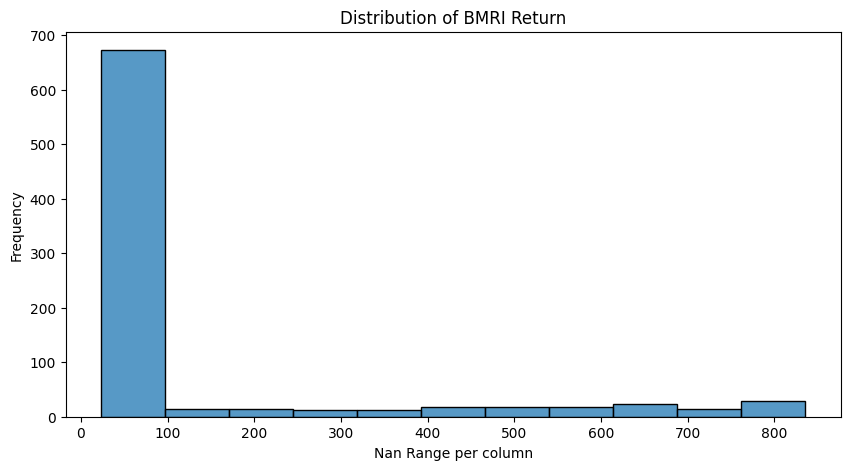

PACK.JK    802
VAST.JK    802
CHIP.JK    802
HALO.JK    802
KING.JK    808
          ... 
PEVE.JK    791
LAJU.JK    794
FWCT.JK    797
NAYZ.JK    800
IRSX.JK    801
Length: 848, dtype: int64

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

raw_dataset = util.pickle_load(config_data['raw_dataset_path'])
df_nan = raw_dataset.isna().sum()
plt.figure(figsize=(10,5))
sns.histplot(df_nan)
plt.xlabel('Nan Range per column')
plt.ylabel('Frequency')
plt.title('Distribution of BMRI Return')
plt.show()

df_nan

In [63]:
corr_stock = raw_dataset.corrwith(raw_dataset['BMRI.JK'], axis=0, numeric_only=True).nlargest(10)


In [64]:
corr_stock

BMRI.JK    1.000000
BBNI.JK    0.941403
BBCA.JK    0.934069
AKRA.JK    0.933284
FAPA.JK    0.932111
ITMG.JK    0.919012
ADMF.JK    0.918415
PANS.JK    0.907347
BSSR.JK    0.906998
LTLS.JK    0.897699
dtype: float64

In [65]:
raw_dataset_feng = transform_to_stock_return(dataset=raw_dataset, params=config_data)


In [66]:
raw_dataset_feng.corrwith(raw_dataset_feng['BMRI.JK Return D+2'], axis=0, numeric_only=True).nlargest(10)


BMRI.JK Return D+2    1.000000
CHEM.JK               0.315694
PTMP.JK               0.292321
BUKA.JK               0.187069
CHIP.JK               0.160408
ALKA.JK               0.150020
DMMX.JK               0.142654
SAGE.JK               0.141244
TRIN.JK               0.117936
NAYZ.JK               0.115414
dtype: float64

In [67]:
valid_set_feng = transform_to_stock_return(dataset=valid_set, params=config_data)

In [74]:
test_set.corrwith(test_set['BMRI.JK'], axis=0, numeric_only=True).nlargest(10)


BMRI.JK    1.000000
BBCA.JK    0.966422
BBNI.JK    0.966078
TKIM.JK    0.957764
PANS.JK    0.957426
FAPA.JK    0.954329
INKP.JK    0.949223
MAPI.JK    0.948928
DYAN.JK    0.945072
AMAN.JK    0.943760
dtype: float64

In [70]:
valid_set.describe()

,PACK.JK,VAST.JK,CHIP.JK,HALO.JK,KING.JK,PGEO.JK,FUTR.JK,HILL.JK,BDKR.JK,PTMP.JK,...,SUNI.JK,CBRE.JK,WINE.JK,BMBL.JK,PEVE.JK,LAJU.JK,FWCT.JK,NAYZ.JK,IRSX.JK,BMRI.JK
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,...,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,47.476190,39.419048,296.514286,58.504762,55.819048,209.714286,33.009524,440.190476,55.485714,33.285714,...,172.933333,49.400000,195.371429,42.019048,91.561905,124.323810,48.609524,35.990476,42.000000,4726.450070
std,62.583805,50.811261,471.205168,82.105481,85.689262,351.595148,56.916014,799.407209,105.362024,66.226115,...,147.670649,51.284763,184.698676,41.680788,95.960421,147.397389,57.336305,44.756713,54.528574,987.090028
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4721.505859
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,292.000000,51.000000,282.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4780.970703
75%,108.000000,99.000000,442.000000,117.000000,133.000000,655.000000,100.000000,0.000000,0.000000,0.000000,...,298.000000,79.000000,324.000000,65.000000,191.000000,272.000000,110.000000,87.000000,92.000000,4888.007812
max,166.000000,120.000000,1460.000000,300.000000,264.000000,875.000000,163.000000,2140.000000,268.000000,212.000000,...,320.000000,195.000000,705.000000,170.000000,244.000000,398.000000,159.000000,113.000000,170.000000,10225.000000


In [79]:
train_set_trial = (train_set-train_set.shift(periods=1))*100/train_set.shift(periods=1)



PACK.JK    632
VAST.JK    632
CHIP.JK    632
HALO.JK    632
KING.JK    632
          ... 
LAJU.JK    632
FWCT.JK    632
NAYZ.JK    632
IRSX.JK    632
BMRI.JK     12
Length: 847, dtype: int64

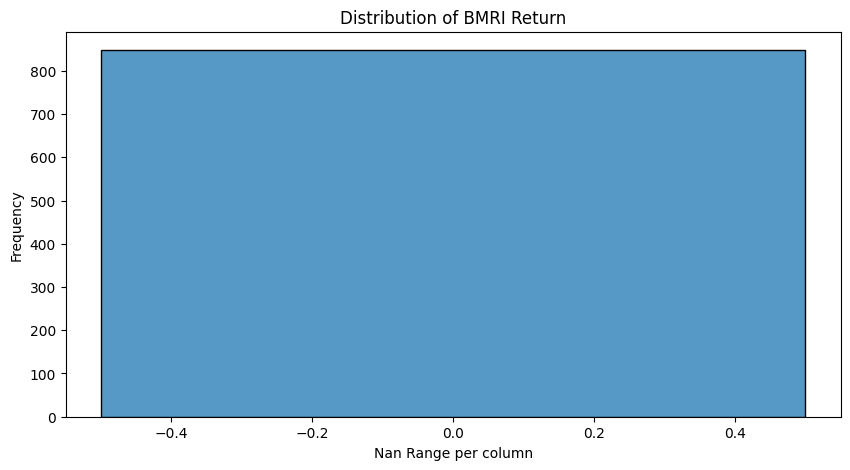

In [95]:
plt.figure(figsize=(10,5))
sns.histplot(train_set_feng.isna().sum())
plt.xlabel('Nan Range per column')
plt.ylabel('Frequency')
plt.title('Distribution of BMRI Return')
plt.show()

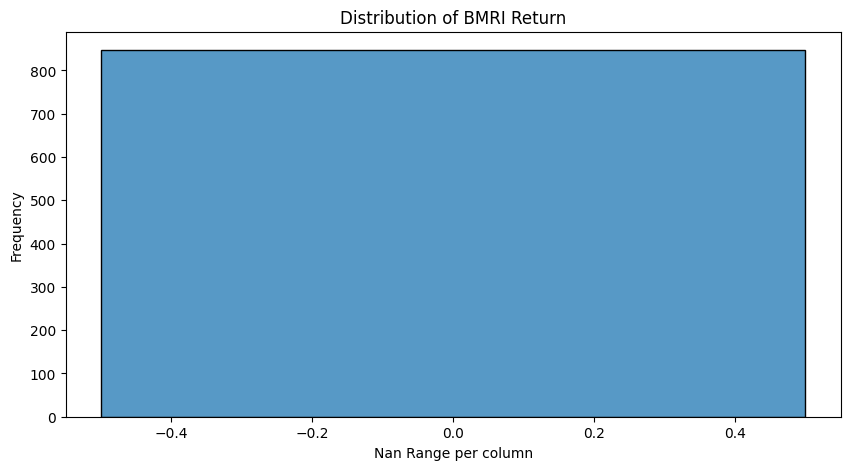

In [82]:
plt.figure(figsize=(10,5))
sns.histplot(train_set.isna().sum())
plt.xlabel('Nan Range per column')
plt.ylabel('Frequency')
plt.title('Distribution of BMRI Return')
plt.show()

In [83]:
raw_dataset

,PACK.JK,VAST.JK,CHIP.JK,HALO.JK,KING.JK,PGEO.JK,FUTR.JK,HILL.JK,BDKR.JK,PTMP.JK,...,CBPE.JK,SUNI.JK,CBRE.JK,WINE.JK,BMBL.JK,PEVE.JK,LAJU.JK,FWCT.JK,NAYZ.JK,IRSX.JK
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,155.0,112.0,1460.0,212.0,252.0,695.0,109.0,2020.0,256.0,185.0,...,150.0,292.0,55.0,550.0,72.0,161.0,326.0,98.0,96.0,119.0
2023-04-03,154.0,114.0,1460.0,220.0,264.0,655.0,121.0,2030.0,258.0,190.0,...,149.0,294.0,54.0,585.0,71.0,157.0,318.0,95.0,100.0,140.0
2023-04-04,164.0,114.0,1460.0,260.0,256.0,660.0,115.0,1990.0,258.0,196.0,...,149.0,296.0,56.0,565.0,64.0,182.0,312.0,99.0,105.0,140.0
